<a href="https://colab.research.google.com/github/vimita/Predictive_Modeling-Deep-Learning-/blob/master/Pytorch_modeling_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/my-drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/my-drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
nz_crime_data=pd.read_csv('my-drive/My Drive/Deep Learning(Predictive Policing)/nz_crime_dataset_final_v4.csv', encoding='utf-8-sig')

In [4]:
# Count total NaN at each column in DataFrame
print(nz_crime_data.isnull().sum())

# Count all NaN in a DataFrame (both columns & Rows)
print(nz_crime_data.isnull().sum().sum())

# erase every row (axis=0) that has "any" Null value in it.
nz_crime_data = nz_crime_data.dropna(how='any',axis=0)

YEAR                           0
MONTH                          0
QUARTER                        0
DAY_OF_WEEK                    0
DAY                            0
HOUR                           0
HOUR_PARTITION                 0
MESHBLOCK                      0
AREA_0                         0
AREA_1                         0
WEAPON_TYPE                    0
CRIME_TYPE                     0
3_DAY_AREA_CRIME_MEAN          0
DAY_AREA_CRIME_COUNT           0
MONTH_AREA_CRIME_TYPE_COUNT    0
MONTH_AREA_CRIME_COUNT         0
DAY_AREA_CRIME_RATIO           0
MONTH_AREA_CRIME_RATIO         0
CRIME_RATIO                    0
CRIME_RANK                     0
RISK                           0
dtype: int64
0


In [5]:
nz_crime_data.head(5)

,YEAR,MONTH,QUARTER,DAY_OF_WEEK,DAY,HOUR,HOUR_PARTITION,MESHBLOCK,AREA_0,AREA_1,WEAPON_TYPE,CRIME_TYPE,3_DAY_AREA_CRIME_MEAN,DAY_AREA_CRIME_COUNT,MONTH_AREA_CRIME_TYPE_COUNT,MONTH_AREA_CRIME_COUNT,DAY_AREA_CRIME_RATIO,MONTH_AREA_CRIME_RATIO,CRIME_RATIO,CRIME_RANK,RISK
0,2014,7,3.0,Wednesday,3.0,22.000000,21.0,1190602,Bethlehem.,Tauranga City.,0,Theft and Related Offences,14.0,14,1682,2650,0.005283,0.634717,0.003353,0.240655,0.0
1,2014,7,3.0,Wednesday,3.0,11.880952,9.0,2752700,Methven.,Ashburton District.,0,Theft and Related Offences,2.0,2,223,400,0.005000,0.557500,0.002788,0.397790,1.0
2,2014,7,3.0,Wednesday,3.0,14.280564,12.0,579200,Wesley.,Auckland.,0,Theft and Related Offences,15.0,19,21630,34825,0.000546,0.621106,0.000339,0.753175,2.0
3,2014,7,3.0,Wednesday,3.0,14.600845,12.0,2472800,Riccarton.,Christchurch City.,0,Theft and Related Offences,42.0,47,5807,9503,0.004946,0.611070,0.003022,0.659393,1.0
4,2014,7,3.0,Wednesday,3.0,13.020408,12.0,900100,Beerescourt.,Hamilton City.,0,Theft and Related Offences,9.0,9,2971,5046,0.001784,0.588783,0.001050,0.483313,1.0


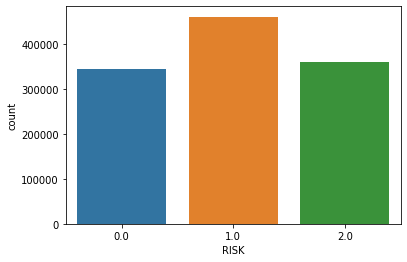

In [7]:
sns.countplot(x ='RISK', data=nz_crime_data)

In [9]:
class2idx = {
    0.0:0,
    1.0:1,
    2.0:2,
   }

idx2class = {v: k for k, v in class2idx.items()}

nz_crime_data['RISK'].replace(class2idx, inplace=True)

In [10]:
feature_var = ['3_DAY_AREA_CRIME_MEAN', 'MONTH', 'DAY', 'QUARTER', 'HOUR_PARTITION', 'AREA_0', 'AREA_1', 'WEAPON_TYPE', 'CRIME_TYPE']
response_var = 'RISK'

X = nz_crime_data[feature_var]
y = nz_crime_data.pop(response_var)



In [11]:
# Encode categorical variables
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
oe.fit(X)
X = oe.transform(X)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [12]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=0)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=0)

In [13]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [14]:
def get_class_distribution(obj):
    count_dict = {
        "rating_0": 0,
        "rating_1": 0,
        "rating_2": 0,
        
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_0'] += 1
        elif i == 1: 
            count_dict['rating_1'] += 1
        elif i == 2: 
            count_dict['rating_2'] += 1        
        else:
            print("Check classes.")
            
    return count_dict

In [15]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [16]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [17]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([6.0589e-06, 4.5289e-06, 5.7896e-06])


In [18]:
class_weights_all = class_weights[target_list]

In [19]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [20]:
EPOCHS = 5
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_FEATURES = 9
NUM_CLASSES = 3

In [21]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [22]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=9, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [26]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [27]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [28]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


Epoch 001: | Train Loss: 0.88414 | Val Loss: 0.84365 | Train Acc: 59.382| Val Acc: 59.589
Epoch 002: | Train Loss: 0.86172 | Val Loss: 0.83438 | Train Acc: 64.533| Val Acc: 59.939
Epoch 003: | Train Loss: 0.85478 | Val Loss: 0.83240 | Train Acc: 65.455| Val Acc: 60.097
Epoch 004: | Train Loss: 0.85051 | Val Loss: 0.83011 | Train Acc: 66.323| Val Acc: 60.804
Epoch 005: | Train Loss: 0.84716 | Val Loss: 0.83391 | Train Acc: 67.048| Val Acc: 60.077



Text(0.5, 1.0, 'Train-Val Loss/Epoch')

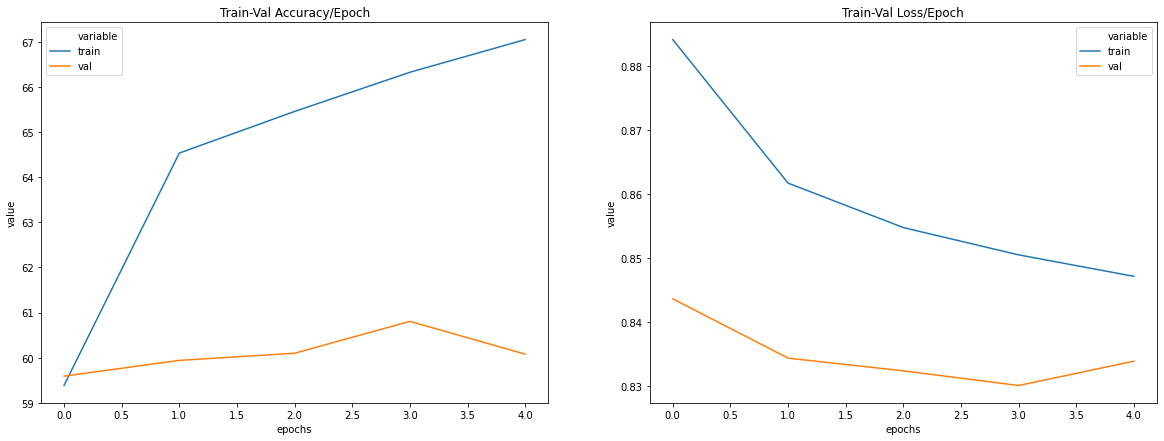

In [29]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [30]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]


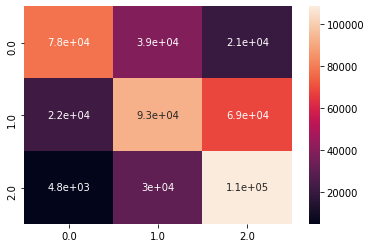

In [31]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [32]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.74      0.57      0.64    137539
           1       0.57      0.51      0.54    184004
           2       0.55      0.75      0.64    143937

    accuracy                           0.60    465480
   macro avg       0.62      0.61      0.61    465480
weighted avg       0.62      0.60      0.60    465480

